In [1]:
%load_ext autoreload
%autoreload 2

# Analyse RBS data from Reis et al. 2020

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
from common import count_ARN_motifs, count_AAN_motifs


top_dir = os.path.join('data', '22_analyse_RBS_data_Reis')
fn = os.path.join('data', 'sb0c00394_si_002.xlsx')
name_sheets = ['RBS Calculator v1.1', 'RBS Calculator v2.0', 'RBS Calculator v2.1']
name_sheet = name_sheets[-1]

In [ ]:
excel_file = pd.ExcelFile(fn)
df = excel_file.parse(name_sheet, index_col=0)
df_aux = excel_file.parse(name_sheets[1], index_col=0)
df['used_mRNA_sequence'] = df_aux['used_mRNA_sequence']
del df_aux

df = df[df['used_mRNA_sequence'].apply(lambda x: type(x) == str)]

print("\nShape of dataframe:", df.shape)


Shape of dataframe: (1014, 37)


In [22]:
df['ARN count'] = df['used_mRNA_sequence'].apply(count_ARN_motifs)
df['AAN count'] = df['used_mRNA_sequence'].apply(count_AAN_motifs)


# ARN motifs vs. predicted DG

<Axes: xlabel='ARN count', ylabel='dG_total'>

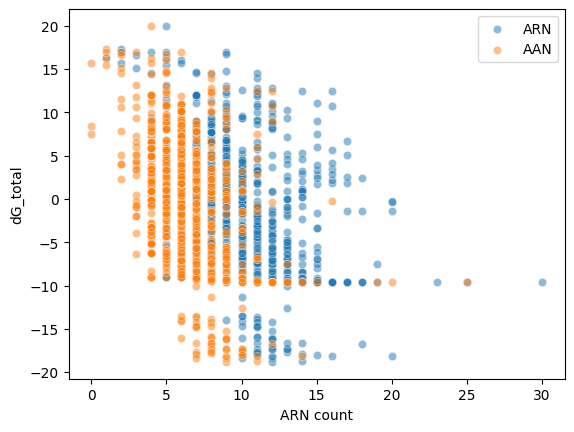

In [25]:
sns.scatterplot(data=df, x='ARN count', y='dG_total', label='ARN', alpha=0.5)
sns.scatterplot(data=df, x='AAN count', y='dG_total', label='AAN', alpha=0.5)